# Using Machine Learning to determine optimal locations for distribution centres

In [1]:
# IMPORT REQUIRED PACKAGES
#
import pandas as pd
import numpy as np
import requests                                   #required for handling API calls
import json                                       #required for handling JSON data
from geopy.geocoders import Nominatim             #required for address conversion
#!conda install -c conda-forge folium=0.5.0 --yes
import folium                                     #required for data visualization

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    ------------------------------------------------------------
                       

## DATA RETRIEVAL FROM WEB SOURCES 

This section retrieves the required geographical data from the Geopy package 
and through Foursquare API Calls. Geopy is used to convert between address and
Latitude & Longitude while Foursquare is used to retrieved all target geographical
coordinated with one API call.

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# RETRIEVE CENTRAL LOCATION FOR ORANGE COUNTY, FLORIDA
#
address = 'Orange County, Florida'
geolocator = Nominatim(user_agent="foursquare_agent") 
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

print('Coordinates for Orange County, Florida are: ', latitude, longitude)

Coordinates for Orange County, Florida are:  28.5421109 -81.3790304


In [70]:
# DOWNLOAD GEOJSON FILE WITH FLORIDA COUNTY BOUNDARIES FOR VISUALIZATION ONLY
# from opendata.myflorida.com
#
!wget https://opendata.arcgis.com/datasets/4abd0a3669204df2bc3a57066d217959_4.geojson -O Florida_Counties.geojson

# Read JSON File Contents to variable
JSON = json.load(open(r'Florida_Counties.geojson'))

--2020-06-11 14:15:49--  https://opendata.arcgis.com/datasets/4abd0a3669204df2bc3a57066d217959_4.geojson
Resolving opendata.arcgis.com (opendata.arcgis.com)... 18.213.21.1, 52.206.220.43, 3.229.60.16
Connecting to opendata.arcgis.com (opendata.arcgis.com)|18.213.21.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘Florida_Counties.geojson’

    [  <=>                                  ] 3,520,495   13.8MB/s   in 0.2s   

2020-06-11 14:15:50 (13.8 MB/s) - ‘Florida_Counties.geojson’ saved [3520495]



In [5]:
# EXTRACT COUNTY NAMES FROM JSON TO CREATE A DATAFRAME WITH ALL COUNTY NAMES
# Create empty dataframe, Extract county names, Assign 1 to Orange County and 0 to all others
#
Florida_counties = pd.DataFrame({'County':[], 'Value':[]})

Features = JSON['features']

for i, feature in zip(range(len(Features)), Features):
    Florida_counties.loc[i,'County']=feature['properties']['COUNTYNAME']
    Florida_counties.loc[i,'Value']= 1 if feature['properties']['COUNTYNAME']=='ORANGE' else 0

Florida_counties

County  Value
0      GILCHRIST    0.0
1         PUTNAM    0.0
2         TAYLOR    0.0
3       OKALOOSA    0.0
4        CALHOUN    0.0
5     PALM BEACH    0.0
6      ST. LUCIE    0.0
7          PASCO    0.0
8        GADSDEN    0.0
9           LEON    0.0
10     JEFFERSON    0.0
11       MADISON    0.0
12       LIBERTY    0.0
13      HAMILTON    0.0
14           BAY    0.0
15      COLUMBIA    0.0
16         BAKER    0.0
17        HOLMES    0.0
18        MARTIN    0.0
19  HILLSBOROUGH    0.0
20       MANATEE    0.0
21          CLAY    0.0
22        HARDEE    0.0
23        MARION    0.0
24       VOLUSIA    0.0
25         DIXIE    0.0
26          LAKE    0.0
27          LEVY    0.0
28        SUMTER    0.0
29      SEMINOLE    0.0
..           ...    ...
37          GULF    0.0
38         UNION    0.0
39      BRADFORD    0.0
40       WAKULLA    0.0
41       BREVARD    0.0
42          POLK    0.0
43       OSCEOLA    0.0
44     HIGHLANDS    0.0
45           LEE    0.0
46       COLLIER    0.0
47          DADE    0.0
48        MONROE    0.0
49    SANTA ROSA    0.0
50        WALTON    0.0
51       JACKSON    0.0
52    WASHINGTON    0.0
53        NASSAU    0.0
54        GLADES    0.0
55     CHARLOTTE    0.0
56      SARASOTA    0.0
57        DESOTO    0.0
58       FLAGLER    0.0
59        HENDRY    0.0
60  INDIAN RIVER    0.0
61       BROWARD    0.0
62      ESCAMBIA    0.0
63    OKEECHOBEE    0.0
64      FRANKLIN    0.0
65       ALACHUA    0.0
66     ST. JOHNS    0.0

[67 rows x 2 columns]

### Visualize Map of Target County

In [6]:
# DISPLAY MAP OF ORANGE COUNTY, FLORIDA USING COORDINATES RETRIEVED
# Use choropleth map to highlight Orange County Boundaries
#
# Save geojson file to variable
fl_geo = r'Florida_Counties.geojson'


map_orange = folium.Map(location=[latitude, longitude], zoom_start=10)

map_orange.choropleth(geo_data=fl_geo,
                  data=Florida_counties,
                  columns=['County','Value'],
                  key_on = 'feature.properties.COUNTYNAME',
                  fill_color='YlOrRd',
                  fill_opacity=0.1,
                  line_opacity=0.5,
                  line_weight=0.5,
                  legend_name='Map Highlighting Orange County, Florida',
                  reset=True)


map_orange

### Use Foursquare to Retrieve Target Data
Target data as defined in problem secenario is all Orange County, High Schools within a 20mile radius of County Center

In [7]:
# SET SEARCH PARAMETERS FOR API CALL TO FOURSQUARE
# Reuest data using REGULAR ENDPOINT: Search within GROUP:Venues
# Limit results to 200 in number and within a 30km Radius of County Center
# 
search_query='High School'
LIMIT=200
RADIUS=30000
# Build Search String
URL = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius{}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, RADIUS, LIMIT)

In [8]:
# RETRIEVE RESULTS FROM FOURSQUARE
# Save to results variable
# 
results = requests.get(URL).json()['response']['venues']
results

[{'id': '4b58cc3ff964a520b56b28e3',
  'name': 'William R. Boone High School',
  'location': {'address': '2000 S Mills Ave',
   'crossStreet': 'Kaley St',
   'lat': 28.51948796222489,
   'lng': -81.36511647712614,
   'labeledLatLngs': [{'label': 'display',
     'lat': 28.51948796222489,
     'lng': -81.36511647712614}],
   'distance': 2862,
   'postalCode': '32806',
   'cc': 'US',
   'city': 'Orlando',
   'state': 'FL',
   'country': 'United States',
   'formattedAddress': ['2000 S Mills Ave (Kaley St)',
    'Orlando, FL 32806',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d13d941735',
    'name': 'High School',
    'pluralName': 'High Schools',
    'shortName': 'High School',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/school_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1591882355',
  'hasPerk': False},
 {'id': '4ed3d964775bbb5f36e55e27',
  'name': 'Boone High School Main Office',
  'location': {'lat': 28.519769930159

## DATA WRANGLING & EXPLORATION

In [9]:
# CHECK TOTAL NUMBER OF RECORDS RETURNED
#
print(len(results), ' records were returned from Foursquare search')

50  records were returned from Foursquare search


In [10]:
# CHECK CATEGORY TYPES FROM RESULTS RETURNED
#
categories=[]
for x in results:
    categories.append(x['categories'][0]['name'])


print('There are {} unique categoty types in the results returned'.format(len(np.unique(categories))))
np.unique(categories)

There are 14 unique categoty types in the results returned


array(['Baseball Field', 'Basketball Court', 'Building', 'Bus Stop',
       'Café', 'College Cafeteria', 'College Gym', 'College Theater',
       'Football Stadium', 'High School', 'Parking', 'Recreation Center',
       'School', 'Theater'], dtype='<U17')

### Create Pandas DataFrame for Further Manipulation

In [51]:
# CREATE EMPTY DICTIONARY THEN EXTRACT REQUIRED INFORMATION
#
Schools={'Name':[], 'Address':[], 'Zip':[], 'City':[], 'School Latitude':[], 'School Longitude':[], 'Category':[]}

for result in results:

    Schools['Name'].append(result['name'])
    try:
        Schools['Address'].append(result['location']['address'])
    except:
        Schools['Address'].append('')
    try:
        Schools['Zip'].append(result['location']['postalCode'])
    except:
        Schools['Zip'].append(0)
    try:
        Schools['City'].append(result['location']['city'])
    except:
        Schools['City'].append('')
    Schools['School Latitude'].append(result['location']['lat'])
    Schools['School Longitude'].append(result['location']['lng'])
    Schools['Category'].append(result['categories'][0]['name'])

schools_df = pd.DataFrame(Schools)
schools_df

Name  \
0                        William R. Boone High School   
1                       Boone High School Main Office   
2                          Boone High School Bus Loop   
3                                Colonial High School   
4                             Winter Park High School   
5                                   Jones High School   
6                             Lake Howell High School   
7                                  Oviedo High School   
8                            Dr. Phillips High School   
9                               Lake Nona High School   
10                  Bishop Moore Catholic High School   
11                                Olympia High School   
12                                Osceola High School   
13                              Oak Ridge High School   
14                               St Cloud High School   
15                          Aloma Charter High School   
16                       Apopka High School gymnasium   
17                               Seminole High School   
18                                Freedom High School   
19                          Lake Brantley High School   
20                             University High School   
21  McCoy Federal Credit Union Athletic Complex at...   
22                              Edgewater High School   
23  Wayne Rickman Gymnasium At William R. Boone Hi...   
24                            West Orange High School   
25         Freedom High School Performing Arts Center   
26                                  Lyman High School   
27                          Cypress Creek High School   
28                                Hagerty High School   
29                             Boone high School Café   
30                         Winter Springs High School   
31                Cypress Creek High School gymnasium   
32                              Lake Mary High School   
33                         Orlando School High School   
34                                 Apopka High School   
35                             South Lake High School   
36                    Freedom High School Parking Lot   
37                Colonial High School Football Field   
38         Seminole High School Alumni Field Baseball   
39                                  Evans High School   
40                                  Jones High School   
41                    Boone High School's Parking Lot   
42                   Edgewater High School Auditorium   
43                  Oviedo High School Softball Field   
44              East Ridge High School Football Field   
45                                 Legacy High School   
46                      Freedom High School Cafeteria   
47           Winter Park High School 9th Grade Center   
48                             East Ridge High School   
49                                 Wekiva High School   

                      Address    Zip               City  School Latitude  \
0            2000 S Mills Ave  32806            Orlando        28.519488   
1                              32806            Orlando        28.519770   
2             1000 E Kaley St  32806            Orlando        28.517567   
3            6100 Oleander Dr  32807            Orlando        28.554220   
4         2100 Summerfield Rd  32792        Winter Park        28.585042   
5        801 S Rio Grande Ave  32805            Orlando        28.532434   
6                4200 Dike Rd  32792        Winter Park        28.637595   
7                 601 King St  32765             Oviedo        28.672018   
8         6500 Turkey Lake Rd  32819            Orlando        28.470967   
9         12500 Narcoossee Rd  32832            Orlando        28.380683   
10          3901 Edgewater Dr  32804            Orlando        28.587962   
11  4301 S Apopka Vineland Rd  32835            Orlando        28.496692   
12          420 S Thacker Ave  34741          Kissimmee        28.288172   
13         700 W Oak Ridge Rd  32809            Orlando        28.472290   
1

In [52]:
# FILTER DATAFRAME TO REMOVE RECORDS THAT ARE NOT HIGH SCHOOLS
#
schools_df = schools_df[schools_df.Category=='High School'].reset_index(drop=True)
schools_df.head()

Name              Address    Zip         City  \
0  William R. Boone High School     2000 S Mills Ave  32806      Orlando   
1          Colonial High School     6100 Oleander Dr  32807      Orlando   
2       Winter Park High School  2100 Summerfield Rd  32792  Winter Park   
3       Lake Howell High School         4200 Dike Rd  32792  Winter Park   
4            Oviedo High School          601 King St  32765       Oviedo   

   School Latitude  School Longitude     Category  
0        28.519488        -81.365116  High School  
1        28.554220        -81.302382  High School  
2        28.585042        -81.322753  High School  
3        28.637595        -81.271969  High School  
4        28.672018        -81.219145  High School

In [53]:
# REMOVE RECORDS WHERE NAME REVEALS IT IS NOT STRICTLY A HIGH SCHOOL
#
schools_df=schools_df[~schools_df.Name.str.contains('Gymnasium')].reset_index(drop=True)
schools_df=schools_df[~schools_df.Name.str.contains('Parking')].reset_index(drop=True)
schools_df=schools_df[~schools_df.Name.str.contains('9th Grade')].reset_index(drop=True)
schools_df=schools_df[~schools_df.Name.str.contains('Football')].reset_index(drop=True)

schools_df.head()

Name              Address    Zip         City  \
0  William R. Boone High School     2000 S Mills Ave  32806      Orlando   
1          Colonial High School     6100 Oleander Dr  32807      Orlando   
2       Winter Park High School  2100 Summerfield Rd  32792  Winter Park   
3       Lake Howell High School         4200 Dike Rd  32792  Winter Park   
4            Oviedo High School          601 King St  32765       Oviedo   

   School Latitude  School Longitude     Category  
0        28.519488        -81.365116  High School  
1        28.554220        -81.302382  High School  
2        28.585042        -81.322753  High School  
3        28.637595        -81.271969  High School  
4        28.672018        -81.219145  High School

In [29]:
# FILL IN MISSING ADDRESSE AND ZIP CODES FROM COORDINATES USING GEOPY
#    
rows=schools_df[schools_df.Address==''].index.tolist()

for row in rows:
    center='{}, {}'.format(schools_df.loc[row,'School Latitude'], schools_df.loc[row,'School Longitude'])
    location=geolocator.reverse(center)
    schools_df.Address[row]='{}, {}'.format(location[0].split(',')[0], location[0].split(',')[1])
    if schools_df.Zip[row]==0:
        schools_df.Zip[row]=int(location[0].split(',')[-2][1:6])

schools_df    

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Name                                Address  \
0        William R. Boone High School                       2000 S Mills Ave   
1                Colonial High School                       6100 Oleander Dr   
2             Winter Park High School                    2100 Summerfield Rd   
3             Lake Howell High School                           4200 Dike Rd   
4                  Oviedo High School                            601 King St   
5            Dr. Phillips High School                    6500 Turkey Lake Rd   
6               Lake Nona High School                    12500 Narcoossee Rd   
7   Bishop Moore Catholic High School                      3901 Edgewater Dr   
8                 Olympia High School              4301 S Apopka Vineland Rd   
9                 Osceola High School                      420 S Thacker Ave   
10              Oak Ridge High School                     700 W Oak Ridge Rd   
11               St Cloud High School                                19th St   
12          Aloma Charter High School                     495 N Semoran Blvd   
13               Seminole High School                     2701 Ridgewood Ave   
14                Freedom High School                2500 W Taft Vineland Rd   
15          Lake Brantley High School                       991 Sand Lake Rd   
16             University High School                      11501 Eastwood Dr   
17              Edgewater High School                      3100 Edgewater Dr   
18            West Orange High School                         1625 Beulah Rd   
19                  Lyman High School               865 S Ronald Reagan Blvd   
20          Cypress Creek High School                  1101 Bear Crossing Dr   
21                Hagerty High School                     3225 Lockwood Blvd   
22         Winter Springs High School                      130 Tuskawilla Rd   
23              Lake Mary High School              655 Longwood Lake Mary Rd   
24         Orlando School High School          West Colonial,  Ferrand Drive   
25                 Apopka High School                          555 Martin St   
26             South Lake High School                  15600 Silver Eagle Rd   
27                  Evans High School                    4949 Silver Star Rd   
28                  Jones High School  Lake Mann Estates,  Cottage Hill Road   
29                 Legacy High School                  1550 E Crown Point Rd   
30             East Ridge High School                     13322 Excalibur Rd   
31                 Wekiva High School                    2501 N Hiawassee Rd   

      Zip               City  School Latitude  School Longitude     Category  
0   32806            Orlando        28.519488        -81.365116  High School  
1   32807            Orlando        28.554220        -81.302382  High School  
2   32792        Winter Park        28.585042        -81.322753  High School  
3   32792        Winter Park        28.637595        -81.271969  High School  
4   32765             Oviedo        28.672018        -81.219145  High School  
5   32819            Orlando        28.470967        -81.476313  High School  
6   32832            Orlando        28.380683        -81.245804  High School  
7   32804            Orlando        28.587962        -81.392106  High School  
8   32835            Orlando        28.496692        -81.505520  High School  
9   34741          Kissimmee        28.288172        -81.426683  High School  
10  32809            Orlando        28.472290        -81.385922  High School  
11  34769        Saint Cloud        28.240517        -81.279506  High School  
12  32807            Orlando        28.547944        -81.310158  High School  
13  32773            Sanford        28.778192        -81.284151  High School  
14  32837            Orlando        28.416581        -81.413558  High School  
15  32714  Altamonte Springs        28.681091        -81.422621  High School  
16  32817            Orlando        28.577263    

### Source Data DataFrame Complete
**No missing data. Proceed to Visualize data on Map**

In [54]:
print('{} Target High Schools have been identified within specified area.'.format(schools_df.shape[0]))

32 Target High Schools have been identified within specified area.


### Data Visualization
Explore physical spread of target schools across Orange County

In [55]:
# VISUALIZE DATA ON FOLIUM MAP
#
map_orange = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, lbl in zip(schools_df['School Latitude'], schools_df['School Longitude'], schools_df.Name):
    label = folium.Popup(lbl, parse_html=True) 
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7, parse_html=False).add_to(map_orange)
    
map_orange

## APPLY MACHINE LEARNING TO CLUSTER SCHOOLS BASED ON LOCATION

In [56]:
# ATTEMPT DENSITY BASED CLUSTERING ON LOCATION DATA WITH DBSCAN
#
# Import Packages
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale input data
X = schools_df.iloc[:,4:6].values
X = StandardScaler().fit_transform(X)

# Employ DBSCAN Model
epsilon =0.5
minimumSamples=6
dbmodel=DBSCAN(eps=epsilon, min_samples=minimumSamples)
dbmodel.fit(X)

dbmodel.labels_    #Multiple attempts at different epsilom values suggests that locations are too widespread 

array([ 0, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1,  0, -1, -1,  0,  0, -1, -1, -1])

### Employ K-means to Cluster Data Set

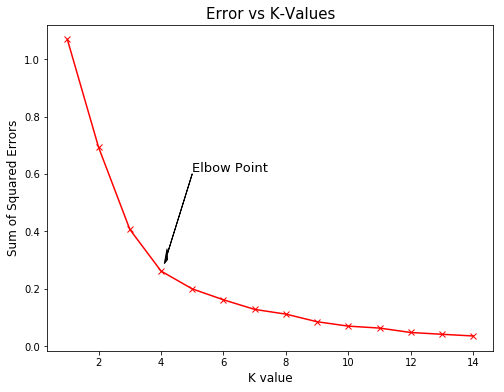

In [57]:
## APPLY PARTITION BASED CLUSTERING ON LOCATION DATA WITH KMEANS
#
# Import Package
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline


# Find the best value for k 
inertias=[]
distortions=[]

for k in range(1,15):
    temp_kmeans = KMeans(init="k-means++", n_clusters=k, n_init=12)
    temp_kmeans.fit(schools_df.iloc[:,4:6].values)
    
    inertias.append(temp_kmeans.inertia_)
    
# Plot Graph
plt.figure(figsize=(8,6))
plt.plot(range(1,15), inertias, '-xr')
plt.arrow(5, 0.6, -0.8, -0.28, head_width=0.04, head_length=0.1, fc='k', ec='k')
plt.xlabel('K value', fontsize=12)
plt.ylabel('Sum of Squared Errors', fontsize=12)
plt.title('Error vs K-Values', fontsize=15)
plt.text(5, 0.61, 'Elbow Point',  color='k', fontsize=13)

plt.savefig('Elbow.png')

plt.show()


In [58]:
# BUILD AND FIT KMEANS MODEL FOR K=4 AS INDICATED ABOVE
#
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=12, random_state=4)
kmeans.fit(schools_df.iloc[:,4:6].values)

kmeans.labels_

array([1, 2, 2, 2, 2, 1, 3, 1, 1, 3, 1, 3, 2, 2, 3, 1, 2, 1, 1, 2, 3, 2,
       2, 2, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int32)

## EXAMINATION OF RESULTS AND INCLUSION IN DATAFRAME

### Add Results from K-Means Clustering back to DataFrame

In [59]:
# MERGE INFORMATION ON CLUSTERS INTO DATAFRAME
#
schools_df_clustered = schools_df
schools_df_clustered.insert(7, 'Cluster', kmeans.labels_)

schools_df_clustered.head()

Name              Address    Zip         City  \
0  William R. Boone High School     2000 S Mills Ave  32806      Orlando   
1          Colonial High School     6100 Oleander Dr  32807      Orlando   
2       Winter Park High School  2100 Summerfield Rd  32792  Winter Park   
3       Lake Howell High School         4200 Dike Rd  32792  Winter Park   
4            Oviedo High School          601 King St  32765       Oviedo   

   School Latitude  School Longitude     Category  Cluster  
0        28.519488        -81.365116  High School        1  
1        28.554220        -81.302382  High School        2  
2        28.585042        -81.322753  High School        2  
3        28.637595        -81.271969  High School        2  
4        28.672018        -81.219145  High School        2

In [60]:
# EXAMINE CLUSTER CENTERS
#
kmeans.cluster_centers_

array([[ 28.5565066 , -81.76637662],
       [ 28.56736717, -81.45334576],
       [ 28.64583597, -81.277227  ],
       [ 28.34134914, -81.34884609]])

In [61]:
# REVERSE LOOKUP OF GEOGRAPHICAL COORDINATES TO RETURN ADDRESS FOR CLUSTER CENTERS
#
Center_locations=[]

for x in kmeans.cluster_centers_:
    center='{}, {}'.format(x[0], x[1])
    location=geolocator.reverse(center)
    Center_locations.append(location[0]) 

Center_locations

['674, W Minneola Ave, Clermont, Lake County, Florida, 34711, United States of America',
 '5340, Ferdinand Drive, Pine Hills, Fairvilla, Orange County, Florida, 32808, United States of America',
 '1009, Chatham Pines Circle, Lost Creek, Bertha, Seminole County, Florida, 32708, United States of America',
 '118, Green Cove Court, Osceola County, Florida, 34743, United States of America']

In [62]:
# REFORMAT CENTER LOCATIONS
# Split string and keep only first few components of address
#
address=[]
for i, location in enumerate(Center_locations):
    address=location.split(sep=',')[0:3]
    Center_locations[i]=('{}, {}, {}.'.format(address[0], address[1], address[2]))

Center_locations

['674,  W Minneola Ave,  Clermont.',
 '5340,  Ferdinand Drive,  Pine Hills.',
 '1009,  Chatham Pines Circle,  Lost Creek.',
 '118,  Green Cove Court,  Osceola County.']

In [63]:
# ADD ADDRESSES FOR CLUSTER CENTERS TO DATAFRAME
#
addresses=[]
for i in range(schools_df_clustered.shape[0]):
    j=int(schools_df_clustered.Cluster[i])
    addresses.append(Center_locations[j])
schools_df_clustered.insert(8,'Central Address', addresses)

schools_df_clustered

Name                    Address    Zip  \
0        William R. Boone High School           2000 S Mills Ave  32806   
1                Colonial High School           6100 Oleander Dr  32807   
2             Winter Park High School        2100 Summerfield Rd  32792   
3             Lake Howell High School               4200 Dike Rd  32792   
4                  Oviedo High School                601 King St  32765   
5            Dr. Phillips High School        6500 Turkey Lake Rd  32819   
6               Lake Nona High School        12500 Narcoossee Rd  32832   
7   Bishop Moore Catholic High School          3901 Edgewater Dr  32804   
8                 Olympia High School  4301 S Apopka Vineland Rd  32835   
9                 Osceola High School          420 S Thacker Ave  34741   
10              Oak Ridge High School         700 W Oak Ridge Rd  32809   
11               St Cloud High School                    19th St  34769   
12          Aloma Charter High School         495 N Semoran Blvd  32807   
13               Seminole High School         2701 Ridgewood Ave  32773   
14                Freedom High School    2500 W Taft Vineland Rd  32837   
15          Lake Brantley High School           991 Sand Lake Rd  32714   
16             University High School          11501 Eastwood Dr  32817   
17              Edgewater High School          3100 Edgewater Dr  32804   
18            West Orange High School             1625 Beulah Rd  34787   
19                  Lyman High School   865 S Ronald Reagan Blvd  32750   
20          Cypress Creek High School      1101 Bear Crossing Dr  32824   
21                Hagerty High School         3225 Lockwood Blvd  32765   
22         Winter Springs High School          130 Tuskawilla Rd  32708   
23              Lake Mary High School  655 Longwood Lake Mary Rd  32746   
24         Orlando School High School                             32804   
25                 Apopka High School              555 Martin St  32712   
26             South Lake High School      15600 Silver Eagle Rd  34736   
27                  Evans High School        4949 Silver Star Rd  32808   
28                  Jones High School                                 0   
29                 Legacy High School      1550 E Crown Point Rd  34761   
30             East Ridge High School         13322 Excalibur Rd  34711   
31                 Wekiva High School        2501 N Hiawassee Rd  32703   

                 City  School Latitude  School Longitude     Category  \
0             Orlando        28.519488        -81.365116  High School   
1             Orlando        28.554220        -81.302382  High School   
2         Winter Park        28.585042        -81.322753  High School   
3         Winter Park        28.637595        -81.271969  High School   
4              Oviedo        28.672018        -81.219145  High School   
5             Orlando        28.470967        -81.476313  High School   
6             Orlando        28.380683        -81.245804  High School   
7             Orlando        28.587962        -81.392106  High School   
8             Orlando        28.496692        -81.505520  High School   
9           Kissimmee        28.288172        -81.426683  High School   
10            Orlando        28.472290        -81.385922  High School   
11        Saint Cloud        28.240517        -81.279506  High School   
12            Orlando        28.547944        -81.310158  High School   
13            Sanford        28.778192        -81.284151  High School   
14            Orlando        28.416581        -81.413558  High School   
15  Altamonte Springs        28.681091        -81.422621  High School   
16            Orlando        28.577263        -81.215476  High School   
17            Orlando        28.581801        -81.390748  High School   
18      Winter Garden        28.540433        -81.568166  High School   
19           Longwood        28.687183        -81.344413  High School   
20            Orlando   

### Visualize Resulting Custers on Map
Visualize Clusters and Center Locations on Map with clusters separated by colors and popup labels for each school

In [64]:
# VISUALIZE CLUSTERS AND CLUSTER CENTERS USING FOLIUM
# 

import matplotlib.cm as cm
import matplotlib.colors as colors

map_clustered = folium.Map(location=[latitude, longitude], zoom_start=9)
cluster_centers = kmeans.cluster_centers_


#Configure color array for different clusters
x = np.arange(len(cluster_centers))
ys = [i + x + (i*x)**2 for i in range(len(cluster_centers))] 
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) 
rainbow = [colors.rgb2hex(i) for i in colors_array]


#Add Circle Marlers for schools, with popup labels and clusters identified by color
for lat, lon, poi, cluster in zip(schools_df_clustered['School Latitude'], schools_df_clustered['School Longitude'], schools_df_clustered['Name'], schools_df_clustered['Cluster']):
    label = folium.Popup(str(poi) + ', Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster-1],
                        fill=True,
                        fill_color=rainbow[cluster-1],
                        fill_opacity=0.7).add_to(map_clustered)

    
#Add Custer Centers in default Marker Style with popup labels   
for i in range(len(cluster_centers)):
    label=folium.Popup(Center_locations[i] + ', Cluster: '+ str(i), parse_html=True)
    folium.Marker([cluster_centers[i][0], cluster_centers[i][1]], popup=label).add_to(map_clustered)

    
map_clustered

### Calculate Actual Point to Point Distances in km between Centers and each School 

In [65]:
# IMPORT PACKAGE FOR CALCULATING DISTANCE BETWEEN TWO POINTS ON EARTHS SURFACE
#
#!pip install haversine


In [66]:
# CALCULATE ACTUAL DISTANCE FROM SCHOOLS TO CLUSTER CENTERS, ADD TO FINAL DATAFRAME
# Distance is Point to Point as measured along the surface of the earth
# using Haversine formula
#
# Import Package
from haversine import haversine, Unit

schools_final = schools_df_clustered

for i in range(cluster_centers.shape[0]):                                                              #iterate through clusters
    cluster_rows=schools_final[schools_final.Cluster==i].shape[0]                                      #find #rows in current cluster
    main_index=schools_final[schools_final.Cluster==i].index                                           #list indicies for current cluster
    for j, k in zip(main_index, range(cluster_rows)):                                                  #iterate main index & current cluster
        cluster_distance=np.zeros(cluster_rows)                                                        #initialize distance array
        loc=(schools_final.loc[j,'School Latitude'], schools_final.loc[j,'School Longitude'])          #get school location
        CC=(cluster_centers[i][0], cluster_centers[i][1])                                              #get center location
        cluster_distance[k]=haversine(loc, CC)                                                         #calculate distance 
        schools_final.loc[j,'Point to Point Distance']=cluster_distance[k]                             #save to main dataframe

schools_final.head()


Name              Address    Zip         City  \
0  William R. Boone High School     2000 S Mills Ave  32806      Orlando   
1          Colonial High School     6100 Oleander Dr  32807      Orlando   
2       Winter Park High School  2100 Summerfield Rd  32792  Winter Park   
3       Lake Howell High School         4200 Dike Rd  32792  Winter Park   
4            Oviedo High School          601 King St  32765       Oviedo   

   School Latitude  School Longitude     Category  Cluster  \
0        28.519488        -81.365116  High School        1   
1        28.554220        -81.302382  High School        2   
2        28.585042        -81.322753  High School        2   
3        28.637595        -81.271969  High School        2   
4        28.672018        -81.219145  High School        2   

                             Central Address  Point to Point Distance  
0       5340,  Ferdinand Drive,  Pine Hills.                10.130058  
1  1009,  Chatham Pines Circle,  Lost Creek.                10.479060  
2  1009,  Chatham Pines Circle,  Lost Creek.                 8.089855  
3  1009,  Chatham Pines Circle,  Lost Creek.                 1.050258  
4  1009,  Chatham Pines Circle,  Lost Creek.                 6.371284

## REPORT OF FINAL ANALYSIS

In [67]:
# DISPLAY REPORT FOR PROPOSED DISTRIBUTION CENTERS AND SCHOOLS SERVED
#
columns=['Name', 'Address', 'City']

for i in range(len(cluster_centers)):
    print('Distribution Center located near: {}'.format(Center_locations[i]))
    print(' should serve the following {} schools,'.format(schools_final[schools_final.Cluster==i].shape[0]))
    print(' at a maximum radial distance of {:.2f} km.'.format(schools_final[schools_final.Cluster==i]['Point to Point Distance'].max()))
    print()
    print(schools_df_clustered[schools_df_clustered['Cluster']==i][columns].to_string(index=False))
    print()
    print()

Distribution Center located near: 674,  W Minneola Ave,  Clermont.
 should serve the following 2 schools,
 at a maximum radial distance of 5.39 km.

                   Name                Address       City
 South Lake High School  15600 Silver Eagle Rd  Groveland
 East Ridge High School     13322 Excalibur Rd   Clermont


Distribution Center located near: 5340,  Ferdinand Drive,  Pine Hills.
 should serve the following 14 schools,
 at a maximum radial distance of 15.59 km.

                              Name                    Address               City
      William R. Boone High School           2000 S Mills Ave            Orlando
          Dr. Phillips High School        6500 Turkey Lake Rd            Orlando
 Bishop Moore Catholic High School          3901 Edgewater Dr            Orlando
               Olympia High School  4301 S Apopka Vineland Rd            Orlando
             Oak Ridge High School         700 W Oak Ridge Rd            Orlando
         Lake Brantley High School

### OPTIONAL: Final DataFrame Output to Excel

In [68]:
#schools_final.sort_values(['Cluster', 'Point to Point Distance']).to_excel('Clustered School.xlsx')